In [218]:
import unittest

import numpy as np
from PIL import Image
from PIL import ImageDraw
import cv2
import chainer
from chainer import Variable
import matplotlib.image as mpimg
from models.proposal_layer import ProposalLayer
from models.bbox_transform import bbox_transform
from models.generate_anchors import generate_anchors as generate_anchors
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'

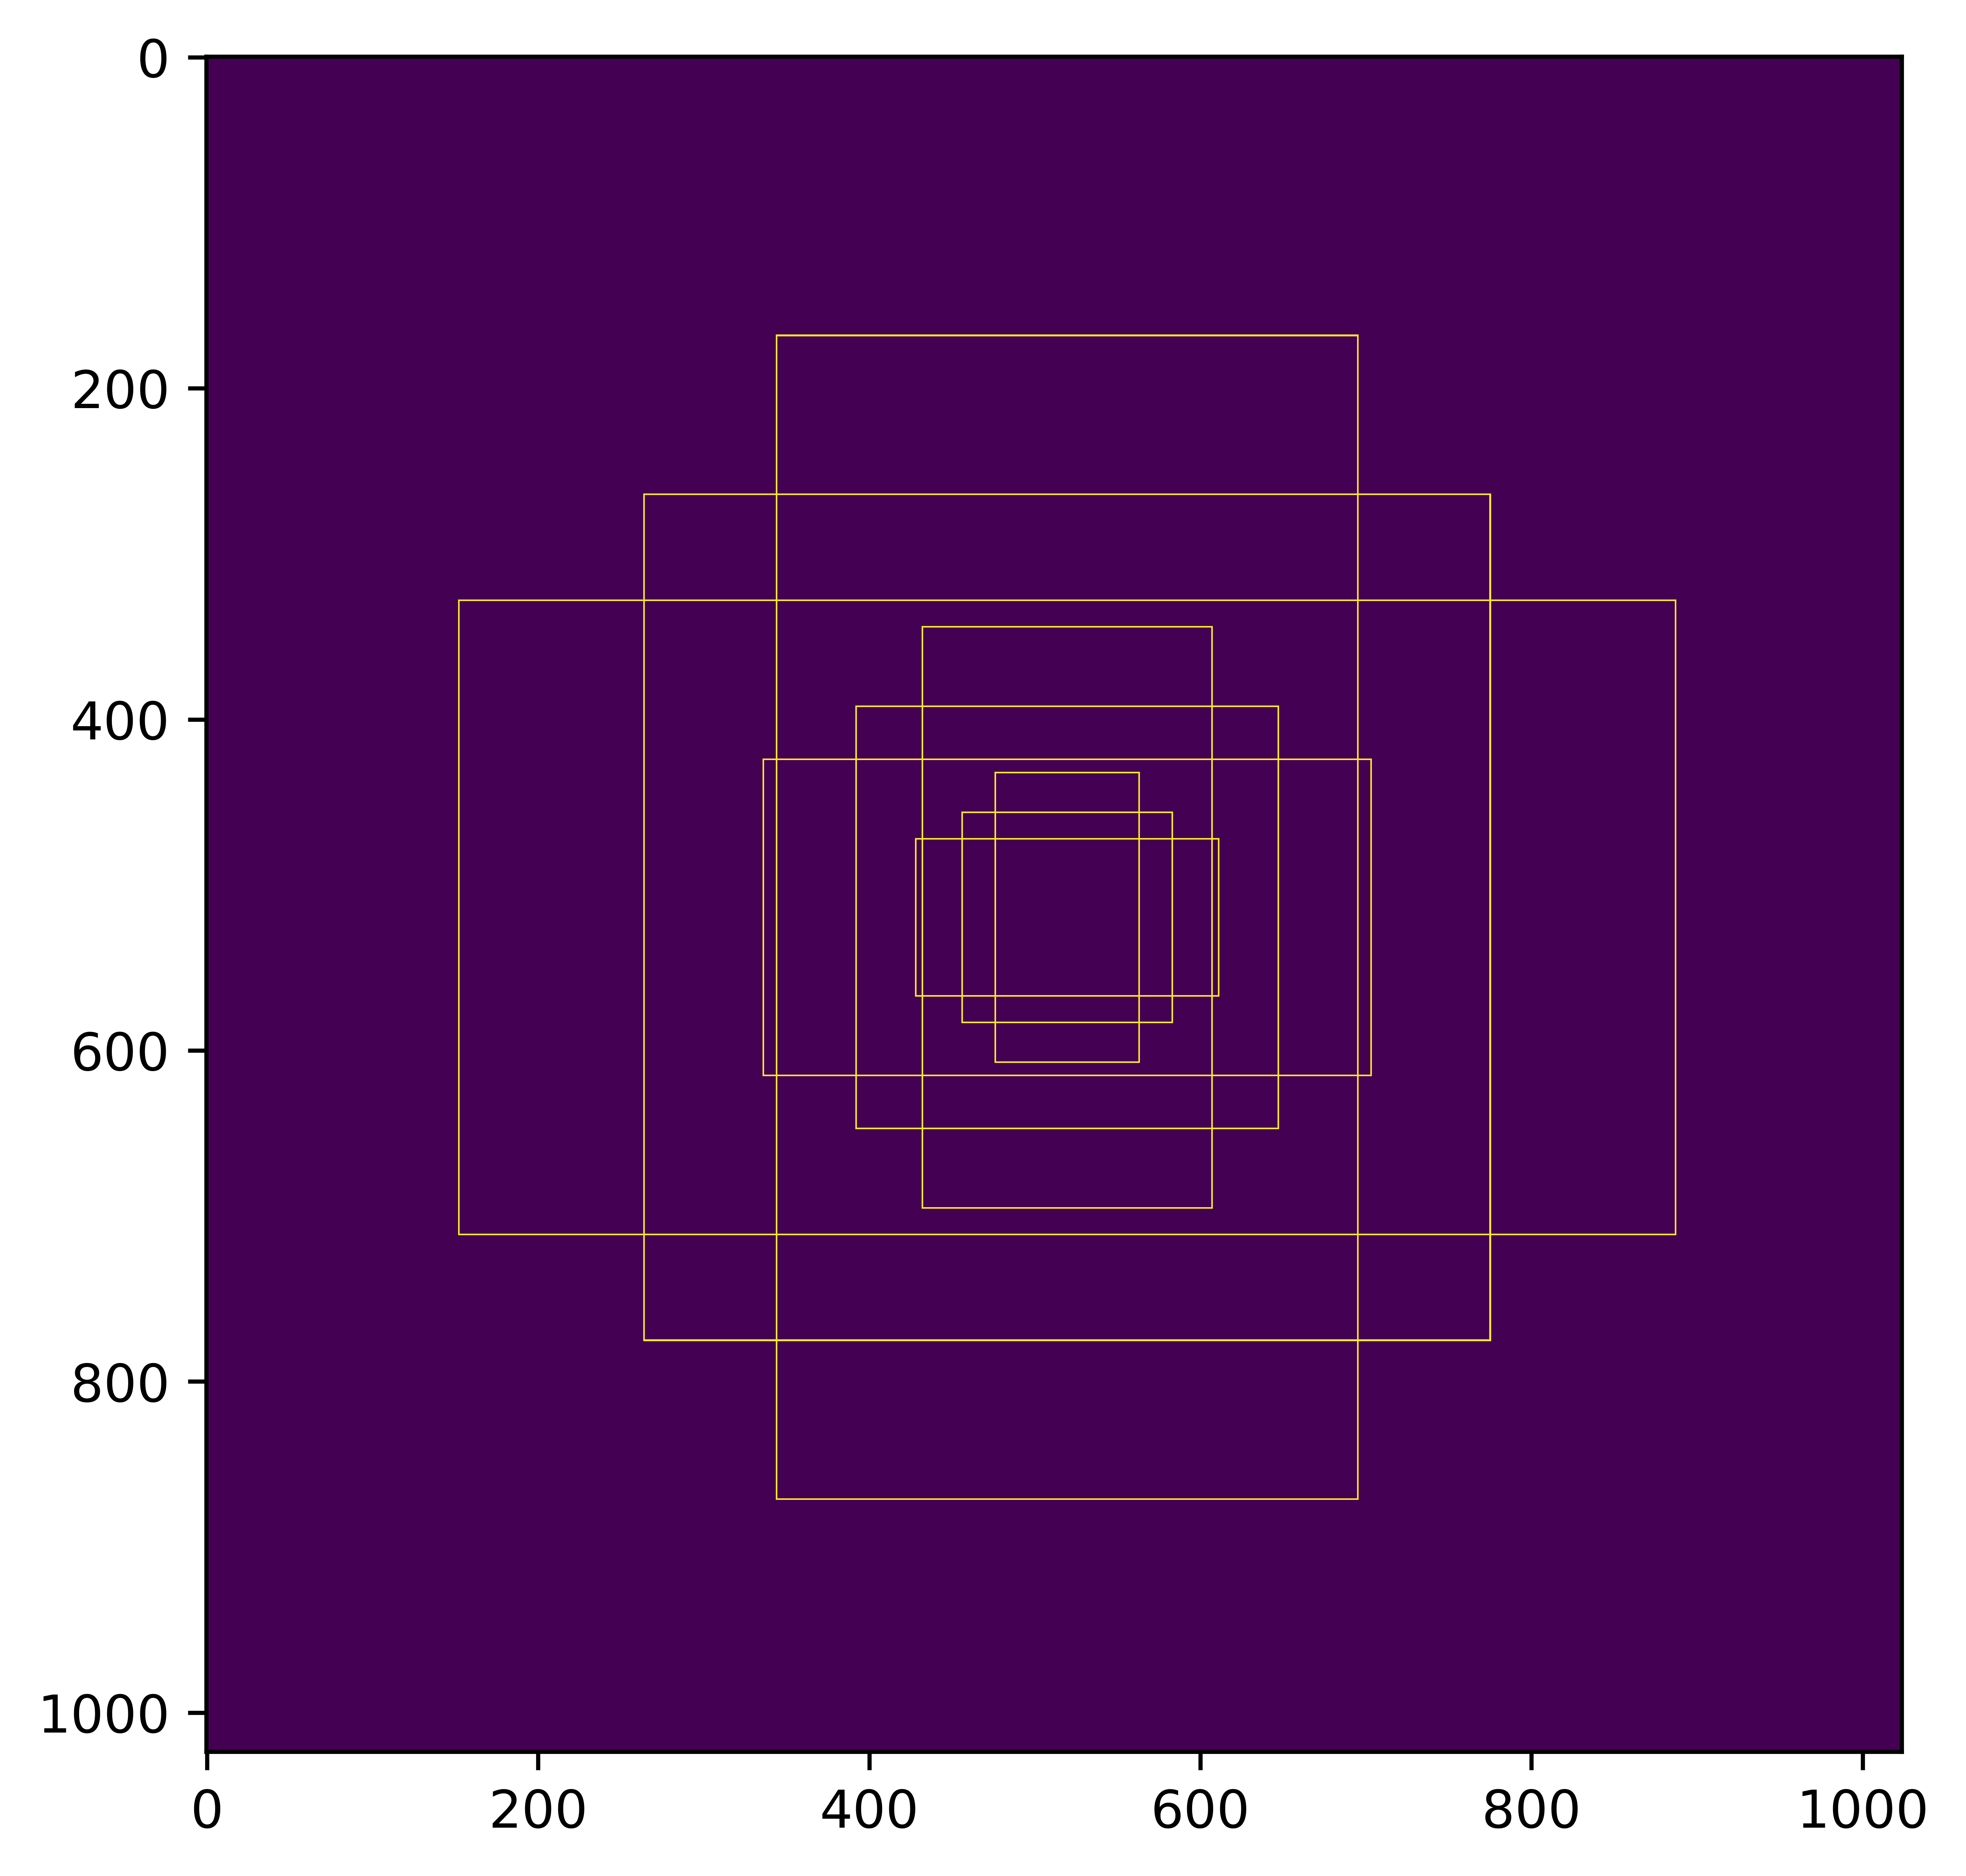

In [219]:
#anchor generate
for bs, r, s in [[15, (0.5, 1, 2), (4, 8, 16, 32)],
                 [15, (0.5, 1, 2), (8, 16, 32)]]:
    anchors = generate_anchors(bs, r, s)
    canvas = Image.fromarray(np.zeros((1024, 1024), dtype='u1'))
    for rec in anchors:
        rec += 512
        draw = ImageDraw.Draw(canvas)
        x0, y0, x1, y1 = rec
        draw.rectangle([x0, y0, x1, y1], None, 255)
    #plt.figure(figsize = (12,6))
    #plt.imshow(canvas)
    #plt.show()
    canvas.save('tests/anchors_{}.png'.format('-'.join([str(a) for a in s])))
anchor_img = mpimg.imread('./tests/anchors_8-16-32.png')
#plt.figure(figsize=(10,10))
plt.figure(figsize = (9,6), dpi = 960)
plt.imshow(anchor_img)

In [220]:
feat_stride = 16
anchor_scales = [8, 16, 32]
proposal_layer = ProposalLayer()
n_anchors = proposal_layer._num_anchors
print(n_anchors)
mat = np.array(proposal_layer._generate_all_bbox(16,16), dtype = np.float32)
print(mat.shape)

9
(2304, 4)


In [221]:
print(mat[0])
boxes = mat

[-84. -40.  99.  55.]


In [222]:
widths = boxes[:, 2] - boxes[:, 0] + 1.0
heights = boxes[:, 3] - boxes[:, 1] + 1.0
ctr_x = boxes[:, 0] + 0.5 * widths
ctr_y = boxes[:, 1] + 0.5 * heights

In [223]:
print(np.min(widths))
print(np.max(heights))
print(np.min(ctr_x))
print(np.max(ctr_y))

88.0
704.0
8.0
248.0


(2400, 4)


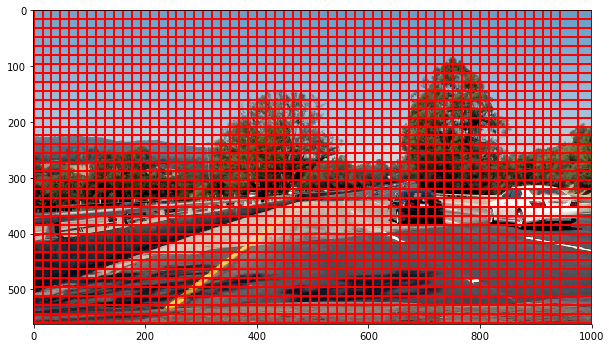

In [224]:
#shifts display on the original image
feat_w = 60
feat_h = 40
shift_x = np.arange(0, feat_w) * feat_stride
shift_y = np.arange(0, feat_h) * feat_stride
shift_x, shift_y = np.meshgrid(shift_x, shift_y)
shifts = np.vstack((shift_x.ravel(), shift_y.ravel(),
                    shift_x.ravel(), shift_y.ravel())).transpose()
print(shifts.shape)
#bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
bbox = ((shifts[:,0], shifts[:,1]),(shifts[:,2],shifts[:,3]))
from PIL import Image
im = Image.open("test4.jpg")
im.thumbnail((1000, 600), Image.ANTIALIAS)
plt.imshow(im)
currentAxis = plt.gca()
for i in range(shifts.shape[0]):
    currentAxis.add_patch(plt.Rectangle((shifts[i,0]-feat_stride, shifts[i,1]-feat_stride), shifts[i,2], shifts[i,3], fill=False, edgecolor= 'r', linewidth=2))


In [225]:
x1 = ctr_x - 0.5 * widths +360
y1 = ctr_y - 0.5 * heights +360
x2 = ctr_x + 0.5 * widths +360
y2 = ctr_y + 0.5 * heights +360
print(np.min(x1),np.min(y1),np.min(x2),np.min(y2))
print(np.max(x1),np.max(y1),np.max(x2),np.max(y2))

0.0 16.0 412.0 416.0
564.0 560.0 976.0 960.0


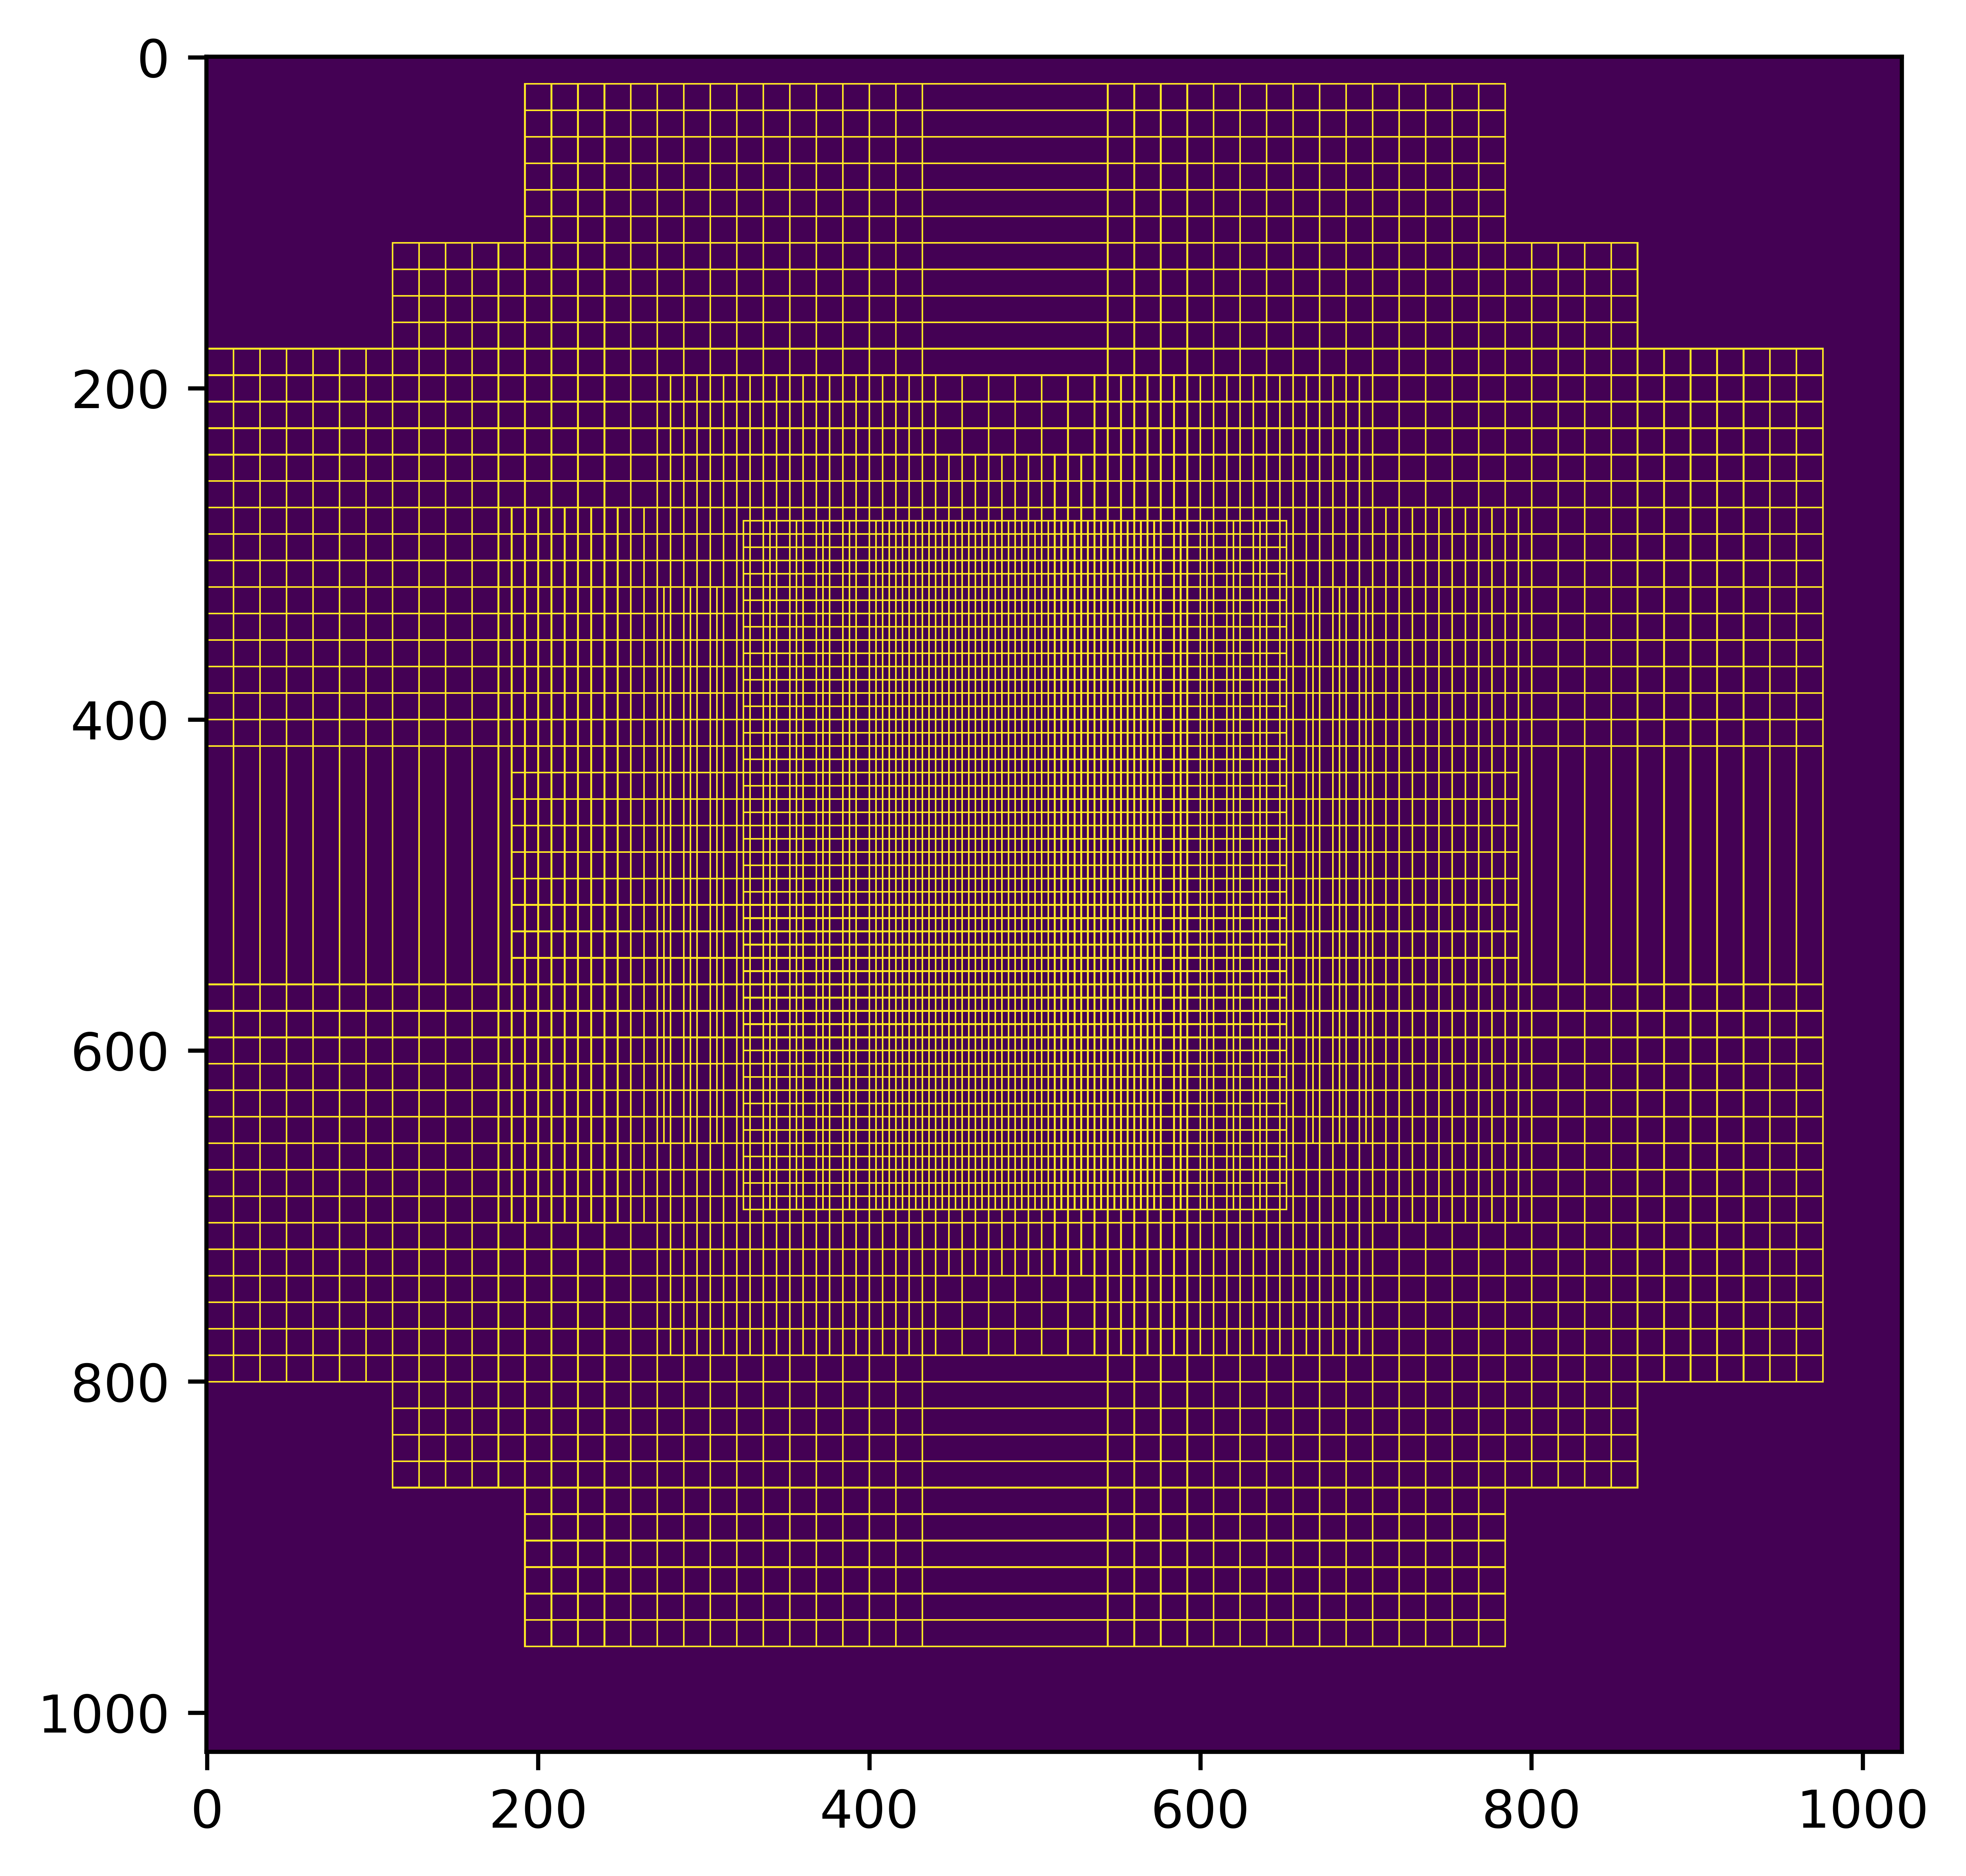

In [200]:
#all anchors(after create anchor windows at all shift points)
canvas = Image.fromarray(np.zeros((1024, 1024), dtype='u1'))
for i in range(x1.shape[0]):
    draw = ImageDraw.Draw(canvas)
    draw.rectangle([x1[i], y1[i], x2[i], y2[i]], None, 255)
canvas.save('tests/anchor_box_{}.png'.format('-'.join([str(a) for a in s])))
anchor_img = mpimg.imread('./tests/anchor_box_8-16-32.png')
#plt.figure(figsize=(10,10))
plt.figure(figsize = (9,6), dpi = 960)
plt.imshow(anchor_img)

In [226]:
# Start faster rcnn conv5_3 feature extract
import chainer
import chainer.links as L
from chainer import optimizers
import chainer.functions as F
from chainer import Variable
import math
import numpy as np

In [270]:
class VGG(chainer.Chain):
    def __init__(self):
        super(VGG, self).__init__(
            conv1_1=L.Convolution2D(3, 64, 3, stride=1, pad=1),
            conv1_2=L.Convolution2D(64, 64, 3, stride=1, pad=1),

            conv2_1=L.Convolution2D(64, 128, 3, stride=1, pad=1),
            conv2_2=L.Convolution2D(128, 128, 3, stride=1, pad=1),

            conv3_1=L.Convolution2D(128, 256, 3, stride=1, pad=1),
            conv3_2=L.Convolution2D(256, 256, 3, stride=1, pad=1),
            conv3_3=L.Convolution2D(256, 256, 3, stride=1, pad=1),

            conv4_1=L.Convolution2D(256, 512, 3, stride=1, pad=1),
            conv4_2=L.Convolution2D(512, 512, 3, stride=1, pad=1),
            conv4_3=L.Convolution2D(512, 512, 3, stride=1, pad=1),

            conv5_1=L.Convolution2D(512, 512, 3, stride=1, pad=1),
            conv5_2=L.Convolution2D(512, 512, 3, stride=1, pad=1),
            conv5_3=L.Convolution2D(512, 512, 3, stride=1, pad=1)
        )
        self.train = False
        self.mean = np.asarray(120, dtype=np.float32)

    def preprocess(self, image):
        return np.rollaxis(image - self.mean, 2)

    def __call__(self, x):
        y1 = F.relu(self.conv1_2(F.relu(self.conv1_1(x))))
        h = F.max_pooling_2d(y1, 2, stride=2)
        y2 = F.relu(self.conv2_2(F.relu(self.conv2_1(h))))
        h = F.max_pooling_2d(y2, 2, stride=2)
        y3 = F.relu(self.conv3_3(F.relu(self.conv3_2(F.relu(self.conv3_1(h))))))
        h = F.max_pooling_2d(y3, 2, stride=2)
        y4 = F.relu(self.conv4_3(F.relu(self.conv4_2(F.relu(self.conv4_1(h))))))
        h = F.max_pooling_2d(y4, 2, stride=2)
        y5 = F.relu(self.conv5_3(F.relu(self.conv5_2(F.relu(self.conv5_1(h))))))
        return [y1, y2, y3, y4, y5]

In [271]:
from chainer import link
from chainer.links.caffe import CaffeFunction
from chainer import serializers

In [272]:
def copy_model(src, dst):
    assert isinstance(src, link.Chain)
    assert isinstance(dst, link.Chain)
    for child in src.children():
        if child.name not in dst.__dict__: continue
        dst_child = dst[child.name]
        if type(child) != type(dst_child): continue
        if isinstance(child, link.Chain):
            copy_model(child, dst_child)
        if isinstance(child, link.Link):
            match = True
            for a, b in zip(child.namedparams(), dst_child.namedparams()):
                if a[0] != b[0]:
                    match = False
                    break
                if a[1].data.shape != b[1].data.shape:
                    match = False
                    break
            if not match:
                print ('Ignore %s because of parameter mismatch' % child.name)
                continue
            for a, b in zip(child.namedparams(), dst_child.namedparams()):
                b[1].data = a[1].data
            print ('Copy %s' % child.name)

In [273]:
#convert the caffemodel(VGG16) to chainer
print ('load VGG16 caffemodel')
ref = CaffeFunction('VGG_ILSVRC_16_layers.caffemodel')
vgg = VGG()
print ('copy weights')
copy_model(ref, vgg)
print ('save "vgg16.model"')
serializers.save_npz('vgg16.model', vgg)

load VGG16 caffemodel
copy weights
Copy conv1_1
Copy conv1_2
Copy conv2_1
Copy conv2_2
Copy conv3_1
Copy conv3_2
Copy conv3_3
Copy conv4_1
Copy conv4_2
Copy conv4_3
Copy conv5_1
Copy conv5_2
Copy conv5_3
save "vgg16.model"


In [293]:
#load test image and output the featuremaps 
from chainer import cuda
#load model
serializers.load_npz('vgg16.model', vgg)
#gpu mode
#cuda.get_device(0).use()
vgg.to_cpu()
xp = np#cuda.cupy
#preprocessing for input image
style = vgg.preprocess(np.asarray(Image.open('test4.jpg').convert('RGB').resize((960,640)), dtype=np.float32))
style = xp.asarray(style, dtype=xp.float32)
#feature extract, so batchsize = 1
batchsize = 1
style_b = xp.zeros((batchsize,) + style.shape, dtype=xp.float32)
for i in range(batchsize):
    style_b[i] = style
#feature extract & output the featuremap
#feature_s = vgg(Variable(style_b, volatile=True))

In [294]:
feature_s = vgg(Variable(style_b, volatile=True))

In [295]:
#featuremap dim of conv5_3
print(np.array(feature_s[4].data).shape)

(1, 512, 40, 60)
